# Chapter 3 - Regression Models 
## Segment 3 - Logistic regression

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pylab import rcParams
from sklearn import preprocessing

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

## Logistic regression on the titanic dataset

In [4]:
address = 'Data/titanic-training-data.csv'
titanic_training = pd.read_csv(address)
titanic_training.columns = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
titanic_training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print(titanic_training.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


##### VARIABLE DESCRIPTIONS

Survived - Survival (0 = No; 1 = Yes)<br>
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
Name - Name<br>
Sex - Sex<br>
Age - Age<br>
SibSp - Number of Siblings/Spouses Aboard<br>
Parch - Number of Parents/Children Aboard<br>
Ticket - Ticket Number<br>
Fare - Passenger Fare (British pound)<br>
Cabin - Cabin<br>
Embarked - Port of Embarkation (C = Cherbourg, France; Q = Queenstown, UK; S = Southampton - Cobh, Ireland)

### Checking that your target variable is binary

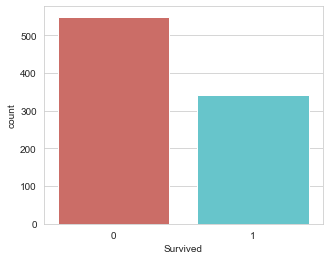

In [6]:
sb.countplot(x='Survived', data=titanic_training, palette='hls')

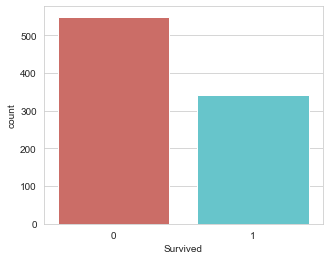

In [7]:
sb.countplot(titanic_training['Survived'], palette='hls')

### Checking for missing values

In [8]:
titanic_training.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
titanic_training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Taking care of missing values
##### Dropping missing values
So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
- Survived - This variable is obviously relevant.
- Pclass - Does a passenger's class on the boat affect their survivability?
- Sex - Could a passenger's gender impact their survival rate?
- Age - Does a person's age impact their survival rate?
- SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
- Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
- Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
- Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.

What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

In [10]:
titanic_data = titanic_training.drop(['Name', 'Ticket', 'Cabin'], axis=1)
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


### Imputing missing values

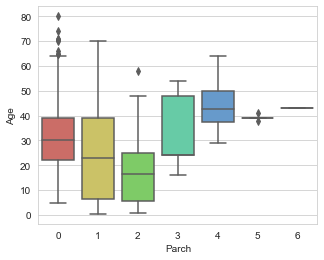

In [11]:
sb.boxplot(x='Parch', y='Age', data=titanic_data, palette='hls')

In [12]:
Parch_groups = titanic_data.groupby(titanic_data['Parch'])
Parch_groups.mean()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
Parch,,,,,,
0,445.255162,0.343658,2.321534,32.178503,0.237463,25.586774
1,465.110169,0.550847,2.203390,24.422000,1.084746,46.778180
2,416.662500,0.500000,2.275000,17.216912,2.062500,64.337604
3,579.200000,0.600000,2.600000,33.200000,1.000000,25.951660
4,384.000000,0.000000,2.500000,44.500000,0.750000,84.968750
5,435.200000,0.200000,3.000000,39.200000,0.600000,32.550000
6,679.000000,0.000000,3.000000,43.000000,1.000000,46.900000


In [13]:
def age_approx(cols):
    Age = cols[0]
    Parch = cols[1]
    
    if pd.isnull(Age):
        if Parch == 0:
            return 32
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        else:
            return 30
        
    else:
        return Age

In [14]:
titanic_data['Age']= titanic_data[['Age', 'Parch']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64

In [15]:
titanic_data.dropna(inplace=True)
print(titanic_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 69.5+ KB
None


In [16]:
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [17]:
titanic_data.reset_index(inplace=True, drop=True)

In [18]:
print(titanic_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.6+ KB
None


In [19]:
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


### Converting categorical variables to a dummy indicators

In [20]:
le = LabelEncoder()
le.fit(titanic_data[['Embarked']].values)
print(le.classes_)
print(le.transform(titanic_data[['Embarked']].values)[:5])

['C' 'Q' 'S']
[2 0 2 2 2]


/Users/sometheasiek/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sometheasiek/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
sex_encoded = le.fit_transform(titanic_data['Sex'])
sex_encoded[:5]

array([1, 0, 0, 0, 1])

In [22]:
titanic_data['Sex'].head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [23]:
# 1 = Male
# 0 = Female

sex_df = pd.DataFrame(sex_encoded, columns=['MaleSex'])
sex_df.head()

,MaleSex
0,1
1,0
2,0
3,0
4,1


In [24]:
embarked_encoded = le.fit_transform(titanic_data['Embarked'])
embarked_encoded[:5]

array([2, 0, 2, 2, 2])

In [25]:
# One hot encode Embarked column
binary_encoder = OneHotEncoder(categories='auto')

In [26]:
embarked_encoded.reshape(-1,1)

array([[2],
       [0],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [0],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [0],
       [2],
       [1],
       [2],
       [0],
       [0],
       [1],
       [2],
       [0],
       [2],
       [0],
       [2],
       [2],
       [0],
       [2],
       [2],
       [0],
       [0],
       [1],
       [2],
       [1],
       [1],
       [0],
       [2],
       [2],
       [2],
       [0],
       [2],
       [0],
       [2],
       [2],
       [0],
       [2],
       [2],
       [0],
       [2],
       [2],
       [0],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
    

In [27]:
embarked_1hot = binary_encoder.fit_transform(embarked_encoded.reshape(-1,1))
embarked_1hot

<889x3 sparse matrix of type '<class 'numpy.float64'>'
	with 889 stored elements in Compressed Sparse Row format>

In [28]:
embarked_1hot_mat = embarked_1hot.toarray()
embarked_1hot_mat

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [29]:
embarked_df = pd.DataFrame(embarked_1hot_mat, columns=['C','Q','S'])
embarked_df.head()

,C,Q,S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [30]:
titanic_data.drop(['Sex', 'Embarked'], axis=1, inplace=True)
titanic_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [31]:
titanic_dmy = pd.concat([titanic_data, sex_df, embarked_df], axis=1, verify_integrity=True).astype(float)
titanic_dmy.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,MaleSex,C,Q,S
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500,1.0,0.0,0.0,1.0
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,0.0
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,1.0
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,1.0
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500,1.0,0.0,0.0,1.0


### Checking for independence between features

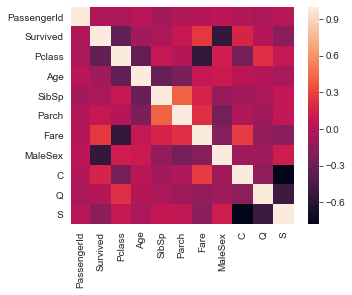

In [32]:
sb.heatmap(titanic_dmy.corr())

In [33]:
titanic_dmy.drop(['Pclass', 'Fare'], axis=1, inplace=True)
titanic_dmy.head()

,PassengerId,Survived,Age,SibSp,Parch,MaleSex,C,Q,S
0,1.0,0.0,22.0,1.0,0.0,1.0,0.0,0.0,1.0
1,2.0,1.0,38.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3.0,1.0,26.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.0,1.0,35.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5.0,0.0,35.0,0.0,0.0,1.0,0.0,0.0,1.0


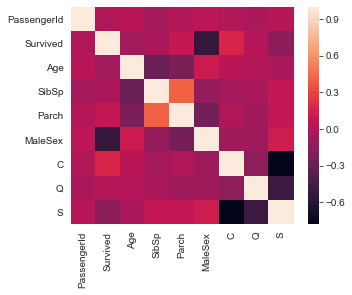

In [34]:
sb.heatmap(titanic_dmy.corr())

### Checking that your dataset size is sufficient

In [35]:
titanic_dmy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
PassengerId    889 non-null float64
Survived       889 non-null float64
Age            889 non-null float64
SibSp          889 non-null float64
Parch          889 non-null float64
MaleSex        889 non-null float64
C              889 non-null float64
Q              889 non-null float64
S              889 non-null float64
dtypes: float64(9)
memory usage: 62.6 KB


In [36]:
X = titanic_dmy.drop(['Survived', 'PassengerId'], axis=1)
y = titanic_dmy['Survived']

In [37]:
X.head()

,Age,SibSp,Parch,MaleSex,C,Q,S
0,22.0,1.0,0.0,1.0,0.0,0.0,1.0
1,38.0,1.0,0.0,0.0,1.0,0.0,0.0
2,26.0,0.0,0.0,0.0,0.0,0.0,1.0
3,35.0,1.0,0.0,0.0,0.0,0.0,1.0
4,35.0,0.0,0.0,1.0,0.0,0.0,1.0


In [38]:
y.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

In [40]:
print(X_train.shape)
print(y_train.shape)

(711, 7)
(711,)


In [41]:
X_train[:5]

,Age,SibSp,Parch,MaleSex,C,Q,S
719,6.0,0.0,1.0,0.0,0.0,0.0,1.0
165,24.0,0.0,1.0,0.0,0.0,0.0,1.0
879,33.0,0.0,0.0,1.0,0.0,0.0,1.0
451,30.0,0.0,0.0,1.0,1.0,0.0,0.0
181,9.0,4.0,2.0,1.0,0.0,0.0,1.0


In [42]:
y_train[:5]

719    1.0
165    1.0
879    0.0
451    0.0
181    0.0
Name: Survived, dtype: float64

### Deploying and evaluating the model

In [43]:
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
y_pred = LogReg.predict(X_test)

## Model Evaluation
### Classification report without cross-validation

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85       109
         1.0       0.79      0.71      0.75        69

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178



### K-fold cross-validation & confusion matrices

In [46]:
y_train_pred = cross_val_predict(LogReg, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[379,  61],
       [ 91, 180]])

In [47]:
precision_score(y_train, y_train_pred)

0.7468879668049793

### Make a test prediction

In [48]:
titanic_dmy[863:864]

,PassengerId,Survived,Age,SibSp,Parch,MaleSex,C,Q,S
863,866.0,1.0,42.0,0.0,0.0,0.0,0.0,0.0,1.0


In [49]:
test_passenger = np.array([40,0,0,0,0,0,1]).reshape(1,-1)
test_passenger

array([[40,  0,  0,  0,  0,  0,  1]])

In [50]:
LogReg.predict(test_passenger)

array([1.])

In [51]:
LogReg.predict_proba(test_passenger)

array([[0.26988808, 0.73011192]])